In [1]:
# MIT License

# Copyright (c) [2019] [Jayden Booth]

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

# Import Libraries
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Input, Dense, GaussianNoise,Lambda,Dropout, Concatenate
from keras.models import Model
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam,SGD
from keras import backend as K
from keras.constraints import max_norm
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy import special

Using TensorFlow backend.


In [2]:
# Set random seeds
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(3)

In [3]:
# Set the defining parameters
# n = n_channel complex numbers (so 2n real numbers)
# k = log2(M), where M is the number of messages to encode
# EbNo is the energy per bit to noise power density

# Encoder Parameters
M = 16
k = np.log2(M)
n_channel = 1
R = k/n_channel

#Power splitting ratio
rho = 0
eps=1
eta=1
print('number of symbols:',M)



number of symbols: 16


In [ ]:
def set_up_train_nn(P):
    label = np.random.randint(M,size=N)

    # creating one hot encoded vectors
    data = []
    for i in label:
        temp = np.zeros(M)
        temp[i] = 1
        data.append(temp)

    # checking data shape
    data = np.array(data)
    print (data.shape)


    # Defined Autoencoder
    batch_size = 4096
    
    # Transmitter Layers
    input_signal = Input(shape=(M,))
    encoded = Dense(M, activation='relu')(input_signal)
    encoded = Dense(8,activation='relu')(encoded)
    encoded = Dense(4,activation='relu')(encoded)
    encoded2 = Dense(2*n_channel, activation='linear')(encoded)

    # Normalize Power
    encoded3 = BatchNormalization(momentum=0,epsilon=1e-6,center=False,scale=False,axis=1)(encoded2)
    encoded3 = Lambda(lambda x: x*np.sqrt(P/2))(encoded3)

    #adding channel noise
    encoded4 = Lambda(lambda x: x+K.random_normal_variable((32768*2,2), 0,np.sqrt(0))[0:tf.shape(x)[0],:])(encoded3)


    # Slicing into CD and PD data, and applying noise

    cd_data = Lambda(lambda x: np.sqrt(rho)*np.sqrt(eps)*x)(encoded4)
    cd_data = Lambda(lambda x: x+K.random_normal_variable((32768*2,2), 0,np.sqrt(0.5))[0:tf.shape(x)[0],:])(cd_data)

    
    pd_data = Lambda(lambda x: K.expand_dims((1-rho)*eta*eps*K.sum(K.square(x),axis=1),axis=1))(encoded4)
    pd_data = Lambda(lambda x: x+K.random_normal_variable((32768*2,1), 0,np.sqrt(1))[0:tf.shape(x)[0]])(pd_data)

    #combining the split data to feed the decoder
    data_split=[]
    data_split.append(cd_data)
    data_split.append(pd_data)

    data_split =  Concatenate(axis=1)(data_split)


    # Reciever Layer
    decoded = Dense(2, activation='linear')(data_split)
    decoded = Dense(4, activation='relu')(decoded)
    decoded = Dense(8, activation='relu')(decoded)
    decoded1 = Dense(M, activation='softmax')(decoded)
    autoencoder = Model(input_signal, decoded1)

    adam = Adam(lr=0.075)
    sgd = SGD(lr=0.5)
    autoencoder.compile(optimizer=adam, loss='categorical_crossentropy',metrics=['accuracy','mse'])

    # printing summary of layers and it's trainable parameters 
    print (autoencoder.summary())

    # traning auto encoder
    autoencoder.fit(data, data,
                    epochs=200,
                    batch_size=batch_size)

    # making encoder from full autoencoder
    encoder = Model(input_signal, encoded3)

    # for plotting learned consteallation diagram

    scatter_plot = []
    for i in range(0,M):
        temp = np.zeros(M)
        temp[i] = 1
        scatter_plot.append(encoder.predict(np.expand_dims(temp,axis=0)))
    scatter_plot = np.array(scatter_plot)
    print (scatter_plot.shape)

    # ploting constellation diagram
    import matplotlib.pyplot as plt
    scatter_plot = scatter_plot.reshape(M,2,1)

    plt.scatter(scatter_plot[:,0],scatter_plot[:,1])
    #plt.axis((-2,2,-2,2))
    plt.grid()
    #plt.title('Splitting Receiver: rho = '+str(rho)+' eps = '+str(eps))
    plt.xlabel('I Axis')
    plt.ylabel('Q Axis')
    plt.show()
    p_av = np.sum(np.square(scatter_plot),axis=1)
    print(sum(p_av)/16)

    return autoencoder

(17000, 16)
Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 16)           272         input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 8)            136         dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 4)            36          dense_2[0][0]                    
_________________________

17000/17000 [==============================] - 0s 7us/step - loss: 1.3446 - acc: 0.3579 - mean_squared_error: 0.0444
Epoch 30/200
17000/17000 [==============================] - 0s 11us/step - loss: 1.1645 - acc: 0.4196 - mean_squared_error: 0.0398
Epoch 31/200
17000/17000 [==============================] - 0s 8us/step - loss: 1.0971 - acc: 0.4703 - mean_squared_error: 0.0382
Epoch 32/200
17000/17000 [==============================] - 0s 11us/step - loss: 1.0651 - acc: 0.4676 - mean_squared_error: 0.0373
Epoch 33/200
17000/17000 [==============================] - 0s 6us/step - loss: 1.0766 - acc: 0.4642 - mean_squared_error: 0.0371
Epoch 34/200
17000/17000 [==============================] - 0s 9us/step - loss: 1.0010 - acc: 0.5032 - mean_squared_error: 0.0350
Epoch 35/200
17000/17000 [==============================] - 0s 9us/step - loss: 1.0197 - acc: 0.4748 - mean_squared_error: 0.0356
Epoch 36/200
17000/17000 [==============================] - 0s 8us/step - loss: 1.0151 - acc: 0.5018 

Epoch 92/200
17000/17000 [==============================] - 0s 17us/step - loss: 0.9120 - acc: 0.5734 - mean_squared_error: 0.0329
Epoch 93/200
17000/17000 [==============================] - 0s 21us/step - loss: 0.7982 - acc: 0.6321 - mean_squared_error: 0.0281
Epoch 94/200
17000/17000 [==============================] - 0s 12us/step - loss: 0.7960 - acc: 0.6338 - mean_squared_error: 0.0278
Epoch 95/200
17000/17000 [==============================] - 0s 18us/step - loss: 0.7697 - acc: 0.6597 - mean_squared_error: 0.0264
Epoch 96/200
17000/17000 [==============================] - 0s 19us/step - loss: 0.8465 - acc: 0.6048 - mean_squared_error: 0.0300
Epoch 97/200
17000/17000 [==============================] - 0s 12us/step - loss: 0.7809 - acc: 0.6515 - mean_squared_error: 0.0273
Epoch 98/200
17000/17000 [==============================] - 0s 8us/step - loss: 0.7959 - acc: 0.6436 - mean_squared_error: 0.0276
Epoch 99/200
17000/17000 [==============================] - 0s 9us/step - loss: 0.80

17000/17000 [==============================] - 0s 14us/step - loss: 0.7233 - acc: 0.6709 - mean_squared_error: 0.0251
Epoch 155/200
17000/17000 [==============================] - 0s 10us/step - loss: 0.7547 - acc: 0.6534 - mean_squared_error: 0.0259
Epoch 156/200
17000/17000 [==============================] - 0s 12us/step - loss: 0.8950 - acc: 0.5728 - mean_squared_error: 0.0323
Epoch 157/200
17000/17000 [==============================] - 0s 11us/step - loss: 0.8315 - acc: 0.6074 - mean_squared_error: 0.0298
Epoch 158/200
17000/17000 [==============================] - 0s 12us/step - loss: 0.8027 - acc: 0.6175 - mean_squared_error: 0.0284
Epoch 159/200
17000/17000 [==============================] - 0s 10us/step - loss: 0.7406 - acc: 0.6638 - mean_squared_error: 0.0253
Epoch 160/200
17000/17000 [==============================] - 0s 13us/step - loss: 0.7268 - acc: 0.6691 - mean_squared_error: 0.0248
Epoch 161/200
17000/17000 [==============================] - 0s 12us/step - loss: 0.7457 -

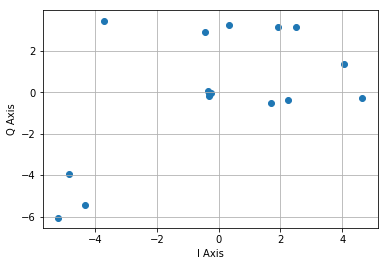

[17.138618]
Es/No: 12 SER: 0.3508235294117647 Theor_SER_PAM: 0.5075803579279314
(24000, 16)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 16)           0                                            
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 16)           272         input_2[0][0]                    
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 8)            136         dense_9[0][0]                    
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 4)            36          dense_10[0][0]                   
_________________

24000/24000 [==============================] - 0s 7us/step - loss: 0.5357 - acc: 0.7826 - mean_squared_error: 0.0199
Epoch 34/200
24000/24000 [==============================] - 0s 7us/step - loss: 0.5278 - acc: 0.7769 - mean_squared_error: 0.0195
Epoch 35/200
24000/24000 [==============================] - 0s 7us/step - loss: 0.6473 - acc: 0.7257 - mean_squared_error: 0.0238
Epoch 36/200
24000/24000 [==============================] - 0s 7us/step - loss: 0.6115 - acc: 0.7140 - mean_squared_error: 0.0236
Epoch 37/200
24000/24000 [==============================] - 0s 6us/step - loss: 0.5401 - acc: 0.7688 - mean_squared_error: 0.0200
Epoch 38/200
24000/24000 [==============================] - 0s 7us/step - loss: 0.5265 - acc: 0.7651 - mean_squared_error: 0.0197
Epoch 39/200
24000/24000 [==============================] - 0s 7us/step - loss: 0.4319 - acc: 0.8291 - mean_squared_error: 0.0156
Epoch 40/200
24000/24000 [==============================] - 0s 7us/step - loss: 0.4741 - acc: 0.8080 - 

24000/24000 [==============================] - 0s 7us/step - loss: 0.2983 - acc: 0.8758 - mean_squared_error: 0.0107
Epoch 97/200
24000/24000 [==============================] - 0s 7us/step - loss: 0.4160 - acc: 0.8176 - mean_squared_error: 0.0157
Epoch 98/200
24000/24000 [==============================] - 0s 8us/step - loss: 0.5501 - acc: 0.7307 - mean_squared_error: 0.0217
Epoch 99/200
24000/24000 [==============================] - 0s 7us/step - loss: 0.4876 - acc: 0.7660 - mean_squared_error: 0.0191
Epoch 100/200
24000/24000 [==============================] - 0s 7us/step - loss: 0.4363 - acc: 0.8078 - mean_squared_error: 0.0165
Epoch 101/200
24000/24000 [==============================] - 0s 8us/step - loss: 0.4667 - acc: 0.7696 - mean_squared_error: 0.0184
Epoch 102/200
24000/24000 [==============================] - 0s 7us/step - loss: 0.3863 - acc: 0.8320 - mean_squared_error: 0.0146
Epoch 103/200
24000/24000 [==============================] - 0s 6us/step - loss: 0.5694 - acc: 0.754

24000/24000 [==============================] - 0s 5us/step - loss: 0.3398 - acc: 0.8427 - mean_squared_error: 0.0129
Epoch 159/200
24000/24000 [==============================] - 0s 5us/step - loss: 0.3174 - acc: 0.8644 - mean_squared_error: 0.0116
Epoch 160/200
24000/24000 [==============================] - 0s 5us/step - loss: 0.2913 - acc: 0.8701 - mean_squared_error: 0.0107
Epoch 161/200
24000/24000 [==============================] - 0s 6us/step - loss: 0.3143 - acc: 0.8560 - mean_squared_error: 0.0118
Epoch 162/200
24000/24000 [==============================] - 0s 6us/step - loss: 0.3125 - acc: 0.8566 - mean_squared_error: 0.0118
Epoch 163/200
24000/24000 [==============================] - 0s 6us/step - loss: 0.2572 - acc: 0.8800 - mean_squared_error: 0.0094
Epoch 164/200
24000/24000 [==============================] - 0s 6us/step - loss: 0.2885 - acc: 0.8644 - mean_squared_error: 0.0108
Epoch 165/200
24000/24000 [==============================] - 0s 5us/step - loss: 0.3284 - acc: 0.

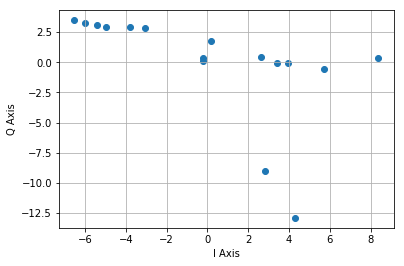

[39.26757]
Es/No: 16 SER: 0.18741666666666668 Theor_SER_PAM: 0.3123019621637889
(32000, 16)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 16)           0                                            
__________________________________________________________________________________________________
dense_17 (Dense)                (None, 16)           272         input_3[0][0]                    
__________________________________________________________________________________________________
dense_18 (Dense)                (None, 8)            136         dense_17[0][0]                   
__________________________________________________________________________________________________
dense_19 (Dense)                (None, 4)            36          dense_18[0][0]                   
_________________

32000/32000 [==============================] - 0s 3us/step - loss: 3.3013 - acc: 0.1235 - mean_squared_error: 0.0578
Epoch 34/200
32000/32000 [==============================] - 0s 3us/step - loss: 3.3011 - acc: 0.1260 - mean_squared_error: 0.0578
Epoch 35/200
32000/32000 [==============================] - 0s 3us/step - loss: 3.3014 - acc: 0.1238 - mean_squared_error: 0.0578
Epoch 36/200
32000/32000 [==============================] - 0s 3us/step - loss: 3.3013 - acc: 0.1251 - mean_squared_error: 0.0578
Epoch 37/200
32000/32000 [==============================] - 0s 3us/step - loss: 3.3016 - acc: 0.1254 - mean_squared_error: 0.0578
Epoch 38/200
32000/32000 [==============================] - 0s 3us/step - loss: 3.3013 - acc: 0.1235 - mean_squared_error: 0.0578
Epoch 39/200
32000/32000 [==============================] - 0s 3us/step - loss: 3.3023 - acc: 0.1247 - mean_squared_error: 0.0578
Epoch 40/200
32000/32000 [==============================] - 0s 3us/step - loss: 3.3015 - acc: 0.1232 - 

32000/32000 [==============================] - 0s 3us/step - loss: 2.7726 - acc: 0.0621 - mean_squared_error: 0.0586
Epoch 97/200
32000/32000 [==============================] - 0s 3us/step - loss: 2.7729 - acc: 0.0645 - mean_squared_error: 0.0586
Epoch 98/200
32000/32000 [==============================] - 0s 3us/step - loss: 2.7730 - acc: 0.0630 - mean_squared_error: 0.0586
Epoch 99/200
32000/32000 [==============================] - 0s 4us/step - loss: 2.7729 - acc: 0.0643 - mean_squared_error: 0.0586
Epoch 100/200
32000/32000 [==============================] - 0s 3us/step - loss: 2.7731 - acc: 0.0597 - mean_squared_error: 0.0586
Epoch 101/200
32000/32000 [==============================] - 0s 3us/step - loss: 2.7728 - acc: 0.0644 - mean_squared_error: 0.0586
Epoch 102/200
32000/32000 [==============================] - 0s 3us/step - loss: 2.7731 - acc: 0.0637 - mean_squared_error: 0.0586
Epoch 103/200
32000/32000 [==============================] - 0s 3us/step - loss: 2.7729 - acc: 0.060

32000/32000 [==============================] - 0s 3us/step - loss: 2.7728 - acc: 0.0629 - mean_squared_error: 0.0586
Epoch 159/200
32000/32000 [==============================] - 0s 3us/step - loss: 2.7729 - acc: 0.0603 - mean_squared_error: 0.0586
Epoch 160/200
32000/32000 [==============================] - 0s 3us/step - loss: 2.7730 - acc: 0.0612 - mean_squared_error: 0.0586
Epoch 161/200
32000/32000 [==============================] - 0s 3us/step - loss: 2.7730 - acc: 0.0632 - mean_squared_error: 0.0586
Epoch 162/200
32000/32000 [==============================] - 0s 3us/step - loss: 2.7731 - acc: 0.0611 - mean_squared_error: 0.0586
Epoch 163/200
32000/32000 [==============================] - 0s 3us/step - loss: 2.7729 - acc: 0.0622 - mean_squared_error: 0.0586
Epoch 164/200
32000/32000 [==============================] - 0s 3us/step - loss: 2.7731 - acc: 0.0618 - mean_squared_error: 0.0586
Epoch 165/200
32000/32000 [==============================] - 0s 3us/step - loss: 2.7731 - acc: 0.

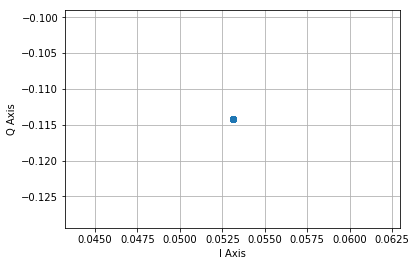

[0.01586232]
Es/No: 20 SER: 0.93584375 Theor_SER_PAM: 0.11723145012290671
(20000, 16)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 16)           0                                            
__________________________________________________________________________________________________
dense_25 (Dense)                (None, 16)           272         input_4[0][0]                    
__________________________________________________________________________________________________
dense_26 (Dense)                (None, 8)            136         dense_25[0][0]                   
__________________________________________________________________________________________________
dense_27 (Dense)                (None, 4)            36          dense_26[0][0]                   
_______________________

20000/20000 [==============================] - 0s 4us/step - loss: 2.7723 - acc: 0.0649 - mean_squared_error: 0.0586
Epoch 34/200
20000/20000 [==============================] - 0s 3us/step - loss: 2.7723 - acc: 0.0655 - mean_squared_error: 0.0586
Epoch 35/200
20000/20000 [==============================] - 0s 3us/step - loss: 2.7722 - acc: 0.0620 - mean_squared_error: 0.0586
Epoch 36/200
20000/20000 [==============================] - 0s 5us/step - loss: 2.7723 - acc: 0.0654 - mean_squared_error: 0.0586
Epoch 37/200
20000/20000 [==============================] - 0s 4us/step - loss: 2.7723 - acc: 0.0654 - mean_squared_error: 0.0586
Epoch 38/200
20000/20000 [==============================] - 0s 3us/step - loss: 2.7723 - acc: 0.0655 - mean_squared_error: 0.0586
Epoch 39/200
20000/20000 [==============================] - 0s 4us/step - loss: 2.7723 - acc: 0.0655 - mean_squared_error: 0.0586
Epoch 40/200
20000/20000 [==============================] - 0s 4us/step - loss: 2.7724 - acc: 0.0655 - 

20000/20000 [==============================] - 0s 3us/step - loss: 2.7723 - acc: 0.0646 - mean_squared_error: 0.0586
Epoch 97/200
20000/20000 [==============================] - 0s 3us/step - loss: 2.7724 - acc: 0.0654 - mean_squared_error: 0.0586
Epoch 98/200
20000/20000 [==============================] - 0s 3us/step - loss: 2.7724 - acc: 0.0662 - mean_squared_error: 0.0586
Epoch 99/200
20000/20000 [==============================] - 0s 4us/step - loss: 2.7723 - acc: 0.0655 - mean_squared_error: 0.0586
Epoch 100/200
20000/20000 [==============================] - 0s 4us/step - loss: 2.7725 - acc: 0.0655 - mean_squared_error: 0.0586
Epoch 101/200
20000/20000 [==============================] - 0s 4us/step - loss: 2.7724 - acc: 0.0652 - mean_squared_error: 0.0586
Epoch 102/200
20000/20000 [==============================] - 0s 3us/step - loss: 2.7723 - acc: 0.0654 - mean_squared_error: 0.0586
Epoch 103/200
20000/20000 [==============================] - 0s 5us/step - loss: 2.7724 - acc: 0.064

20000/20000 [==============================] - 0s 5us/step - loss: 2.7725 - acc: 0.0655 - mean_squared_error: 0.0586
Epoch 159/200
20000/20000 [==============================] - 0s 4us/step - loss: 2.7725 - acc: 0.0648 - mean_squared_error: 0.0586
Epoch 160/200
20000/20000 [==============================] - 0s 4us/step - loss: 2.7724 - acc: 0.0654 - mean_squared_error: 0.0586
Epoch 161/200
20000/20000 [==============================] - 0s 3us/step - loss: 2.7724 - acc: 0.0652 - mean_squared_error: 0.0586
Epoch 162/200
20000/20000 [==============================] - 0s 4us/step - loss: 2.7725 - acc: 0.0634 - mean_squared_error: 0.0586
Epoch 163/200
20000/20000 [==============================] - 0s 4us/step - loss: 2.7725 - acc: 0.0655 - mean_squared_error: 0.0586
Epoch 164/200
20000/20000 [==============================] - 0s 4us/step - loss: 2.7728 - acc: 0.0611 - mean_squared_error: 0.0586
Epoch 165/200
20000/20000 [==============================] - 0s 4us/step - loss: 2.7726 - acc: 0.

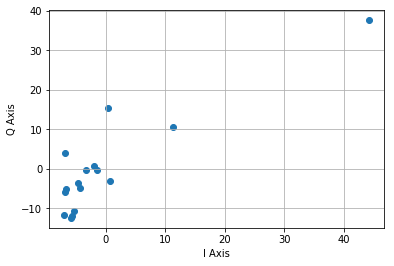

[302.87897]
Es/No: 25 SER: 0.9366 Theor_SER_PAM: 0.00597813169126268
(21000, 16)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 16)           0                                            
__________________________________________________________________________________________________
dense_33 (Dense)                (None, 16)           272         input_5[0][0]                    
__________________________________________________________________________________________________
dense_34 (Dense)                (None, 8)            136         dense_33[0][0]                   
__________________________________________________________________________________________________
dense_35 (Dense)                (None, 4)            36          dense_34[0][0]                   
____________________________

21000/21000 [==============================] - 0s 4us/step - loss: 2.7731 - acc: 0.0666 - mean_squared_error: 0.0586
Epoch 34/200
21000/21000 [==============================] - 0s 4us/step - loss: 2.7729 - acc: 0.0638 - mean_squared_error: 0.0586
Epoch 35/200
21000/21000 [==============================] - 0s 4us/step - loss: 2.7727 - acc: 0.0622 - mean_squared_error: 0.0586
Epoch 36/200
21000/21000 [==============================] - 0s 4us/step - loss: 2.7731 - acc: 0.0624 - mean_squared_error: 0.0586
Epoch 37/200
21000/21000 [==============================] - 0s 4us/step - loss: 2.7730 - acc: 0.0642 - mean_squared_error: 0.0586
Epoch 38/200
21000/21000 [==============================] - 0s 4us/step - loss: 2.7727 - acc: 0.0642 - mean_squared_error: 0.0586
Epoch 39/200
21000/21000 [==============================] - 0s 5us/step - loss: 2.7732 - acc: 0.0622 - mean_squared_error: 0.0586
Epoch 40/200
21000/21000 [==============================] - 0s 5us/step - loss: 2.7728 - acc: 0.0647 - 

C:\Users\u1081001\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249990). Check your callbacks.
  % delta_t_median)


21000/21000 [==============================] - 0s 5us/step - loss: 2.7727 - acc: 0.0666 - mean_squared_error: 0.0586
Epoch 93/200
21000/21000 [==============================] - 0s 4us/step - loss: 2.7730 - acc: 0.0666 - mean_squared_error: 0.0586
Epoch 94/200
21000/21000 [==============================] - 0s 4us/step - loss: 2.7728 - acc: 0.0666 - mean_squared_error: 0.0586
Epoch 95/200
21000/21000 [==============================] - 0s 4us/step - loss: 2.7727 - acc: 0.0651 - mean_squared_error: 0.0586
Epoch 96/200
21000/21000 [==============================] - 0s 4us/step - loss: 2.7734 - acc: 0.0649 - mean_squared_error: 0.0586
Epoch 97/200
21000/21000 [==============================] - 0s 6us/step - loss: 2.7726 - acc: 0.0639 - mean_squared_error: 0.0586
Epoch 98/200
21000/21000 [==============================] - 0s 6us/step - loss: 2.7729 - acc: 0.0639 - mean_squared_error: 0.0586
Epoch 99/200
21000/21000 [==============================] - 0s 5us/step - loss: 2.7729 - acc: 0.0651 - 

In [ ]:
EsNodB_range = [12,16,20,25,26]
N_array=[17000,24000,32000,20000,21000]
ser = [None]*len(EsNodB_range)
theor_ser_qam = [None]*len(EsNodB_range)
theor_ser = [None]*len(EsNodB_range)

noise_std = np.sqrt(1)
for n in range(0,len(EsNodB_range)):
    
    EsNo=10.0**(EsNodB_range[n]/10.0)
    P = EsNo*(noise_std**2)
    
    no_errors = 0
    
    N=N_array[n]
   
    
    autoencoder = set_up_train_nn(P)
    
    # generating data for checking SER
    test_label = np.random.randint(M,size=N)
    test_data = []

    for i in test_label:
        temp = np.zeros(M)
        temp[i] = 1
        test_data.append(temp)

    test_data = np.array(test_data)
    
    pred_final_signal = autoencoder.predict(test_data)
    
    pred_output = np.argmax(pred_final_signal,axis=1)
    no_errors = (pred_output != test_label)
    no_errors =  no_errors.astype(int).sum()
    ser[n] = no_errors / N 
    
    theor_ser[n] = (15/16)*special.erfc(np.sqrt(EsNo/85))
    
    print ('Es/No:',EsNodB_range[n],'SER:',ser[n],'Theor_SER_PAM:',theor_ser[n])
    

In [ ]:
plt.plot(EsNodB_range, theor_ser, 'g--',label='16 PAM')
plt.plot(EsNodB_range, ser, 'bo-',label='Conventional PD-both streams')
plt.yscale('log')
plt.xlabel('SNR Range')
plt.ylabel('Block Error Rate')
plt.grid()
plt.legend(loc='best',ncol = 1)
plt.show()

In [ ]:
ser